In [29]:
import numpy as np
import pandas as pd
import oracledb
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
%pip install hdbscan
from hdbscan import flat
%pip install oracledb
from datetime import datetime
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Extração de dados

In [ ]:
username = 'challenge_totvs'
password = 'ba@2025'
dsn = 'localhost:1522/XEPDB1' 

conexao = oracledb.connect(user=username, password=password, dsn=dsn)
cursor = conexao.cursor()

cursor.execute("SELECT * FROM RFM_CLIENTES")

colunas = [col[0] for col in cursor.description]
dados = cursor.fetchall()

df = pd.DataFrame(dados, columns=colunas)


In [31]:
df.head()

,CD_CLIENTE,DS_PROD,DS_LIN_REC,CIDADE,DS_CNAE,DS_SEGMENTO,DS_SUBSEGMENTO,FAT_FAIXA,MARCA_TOTVS,MODAL_COMERC,PAIS,PERIODICIDADE,SITUACAO_CONTRATO,UF,VL_TOTAL_CONTRATO,DT_ASSINATURA_CONTRATO,QTD_CONTRATACOES_12M,VLR_CONTRATACOES_12M,MRR_12M
0,T00145,SMS TOTVS TEC USER,SMS TOTVS SERIE T,SANTOANDRE,Comercio atacadista de maquinas e equipamentos...,LOGISTICA,ATACADISTA E DISTRIBUIDOR,Faixa 03 - De 15 M ate 25 M,TECNOLOGIA,MODALIDADE TRADICIONAL,105,00 - Mensal,ATIVO,SP,23.46,2010-03-22,1,24.34,222549913
1,T00151,CLOUD EXPRESS SERIE T 24M,CLOUD COMPUTING.,SAOPAULO,Confeccao de roupas intimas,EDUCACIONAL,EDUCACAO CONTINUADA,Faixa 04 - De 25 M ate 35 M,CLOUD,MODALIDADE SERVICOS RECORRENTES,105,00 - Mensal,CANCELADO,SP,413.05,2017-12-29,0,0.00,175290512
2,T00145,APP MEU RH 1 AO 50 ID,SAAS INTERA SOFTWARE,SANTOANDRE,Comercio atacadista de maquinas e equipamentos...,LOGISTICA,ATACADISTA E DISTRIBUIDOR,Faixa 03 - De 15 M ate 25 M,RH - CORE,MODALIDADE ASSINATURA COMPLEMENTAR,105,00 - Mensal,ATIVO,SP,71.85,2023-04-28,1,24.34,222549913
3,T00255,TOTVS TEC USER,CDU TOTVS SERIE T,NOVAODESSA,"Fabricacao de tecidos especiais, inclusive art...",MANUFATURA,BENS DE CONSUMO,Faixa 08 - De 150 M ate 300 M,TECNOLOGIA,MODALIDADE TRADICIONAL,105,00 - Mensal,GRATUITO,SP,0.06,2013-01-28,0,0.00,688874163
4,T00053,PROG OPED STUDIO ND USR MNT,SOFTWARE COMPLEMENTAR,RIODEJANEIRO,Fabricacao de preparacoes farmaceuticas,MANUFATURA,BENS DURAVEIS,Faixa 05 - De 35 M ate 50 M,SOFTWARE COMPLEMENTAR,MODALIDADE SERVICOS NÃO RECORRENTES,105,00 - Mensal,ATIVO,RJ,2473.10,2021-04-29,1,4317.95,448951788


Construção das métricas RFM

In [21]:
df['DT_ASSINATURA_CONTRATO'] = pd.to_datetime(df['DT_ASSINATURA_CONTRATO'], errors='coerce')

data_referencia = datetime.today()

df = df.groupby('CD_CLIENTE').agg({
    'DT_ASSINATURA_CONTRATO': lambda x: (data_referencia - x.max()).days,
    'QTD_CONTRATACOES_12M': 'max',
    'MRR_12M': 'max'
}).rename(columns={
    'DT_ASSINATURA_CONTRATO': 'RECENCIA',
    'QTD_CONTRATACOES_12M': 'FREQUENCIA',
    'MRR_12M': 'MONETARIO'
}).reset_index()

df['R_SCORE'] = pd.qcut(df['RECENCIA'], q=5, labels=[5,4,3,2,1]).astype(int)
df['F_SCORE'] = pd.qcut(df['FREQUENCIA'].rank(method='first'), q=5, labels=[1,2,3,4,5]).astype(int)
df['M_SCORE'] = pd.qcut(df['MONETARIO'].rank(method='first'), q=5, labels=[1,2,3,4,5]).astype(int)
df['RFM_SCORE'] = df['R_SCORE'].astype(str) + df['F_SCORE'].astype(str) + df['M_SCORE'].astype(str)

df['RECENCIA'] = df['RECENCIA'].clip(upper=720)

Transformações estatísticas (Box‑Cox / Yeo‑Johnson)

In [22]:
features = ['RECENCIA', 'FREQUENCIA', 'MONETARIO']
X = df[features].copy()

In [23]:
cols_boxcox = [c for c in features if np.isfinite(X[c]).all() and (X[c].min() > 0)]
cols_yj     = [c for c in features if c not in cols_boxcox]

transformers = []
if cols_boxcox:
    transformers.append(("bc", PowerTransformer(method="box-cox", standardize=False), cols_boxcox))
if cols_yj:
    transformers.append(("yj", PowerTransformer(method="yeo-johnson", standardize=False), cols_yj))

pre = ColumnTransformer(transformers=transformers, remainder="drop")


Clusterização (HDBSCAN)

In [24]:
pre_sc = Pipeline(steps=[
    ("pre", pre),
    ("sc", StandardScaler()),
])

Xt = pre_sc.fit_transform(X).astype(np.float32, copy=False)

clusterer6 = flat.HDBSCAN_flat(
    Xt,
    n_clusters=5,                 
    min_cluster_size=120,
    min_samples=10,
    gen_min_span_tree=True,
    prediction_data=True          
)

labels = clusterer6.labels_
df['CLUSTER'] = labels
df = df[['CD_CLIENTE', 'RECENCIA', 'FREQUENCIA', 'MONETARIO', 'CLUSTER']]

Avaliando o resultado

In [27]:
import numpy as np
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
)
from hdbscan import flat

def cluster_quality_report_on_Xt(Xt, labels, max_sil_samples=4000, rng_seed=42, seeds=range(10)):
    Xt = np.asarray(Xt, dtype=np.float32)
    labels = np.asarray(labels)

    # pontos válidos (exclui ruído -1)
    valid = labels >= 0
    n_valid = int(valid.sum())
    uniq_valid = np.unique(labels[valid])

    out = {}

    # métricas internas (só se houver >=2 clusters válidos)
    if n_valid >= 2 and uniq_valid.size >= 2:
        sil = silhouette_score(
            Xt[valid], labels[valid],
            metric="euclidean",
            sample_size=min(n_valid, max_sil_samples),
            random_state=rng_seed
        )
        db = davies_bouldin_score(Xt[valid], labels[valid])
        ch = calinski_harabasz_score(Xt[valid], labels[valid])
        out.update({
            "silhouette": float(sil),
            "davies_bouldin": float(db),
            "calinski_harabasz": float(ch),
        })
    else:
        out.update({"silhouette": None, "davies_bouldin": None, "calinski_harabasz": None})

    # tamanhos (só clusters válidos) + ruído
    if n_valid > 0:
        sizes_valid = np.bincount(labels[valid].astype(int))
        out["cluster_sizes_valid"] = sizes_valid.tolist()
        out["size_ratio_min_max"] = float(sizes_valid.min() / sizes_valid.max()) if sizes_valid.size > 1 else None
    else:
        out["cluster_sizes_valid"] = []
        out["size_ratio_min_max"] = None
    out["noise_count"] = int((labels == -1).sum())

    # “estabilidade” via bootstrap + novo corte plano (HDBSCAN é determinístico)
    if n_valid >= 2 and uniq_valid.size >= 2:
        rng = np.random.default_rng(rng_seed)
        idx_valid = np.flatnonzero(valid)
        aris = []
        for s in seeds:
            idx_boot = rng.choice(idx_valid, size=n_valid, replace=True)
            hd = flat.HDBSCAN_flat(
                Xt[idx_boot],
                n_clusters=6,
                min_cluster_size=120,
                min_samples=10,
                gen_min_span_tree=True
            )
            aris.append(adjusted_rand_score(labels[idx_boot], hd.labels_))
        out["stability_ari_mean"] = float(np.mean(aris))
        out["stability_ari_std"]  = float(np.std(aris))
    else:
        out["stability_ari_mean"] = None
        out["stability_ari_std"]  = None

    return out

# ---- uso ----
report = cluster_quality_report_on_Xt(Xt, labels)
print(report)

{'silhouette': 0.6705343127250671, 'davies_bouldin': 0.7402831567992469, 'calinski_harabasz': 45970.390625, 'cluster_sizes_valid': [2485, 3816, 827, 1689, 1785], 'size_ratio_min_max': 0.21671907756813416, 'noise_count': 13, 'stability_ari_mean': 0.9788000943212214, 'stability_ari_std': 0.016823631206479932}


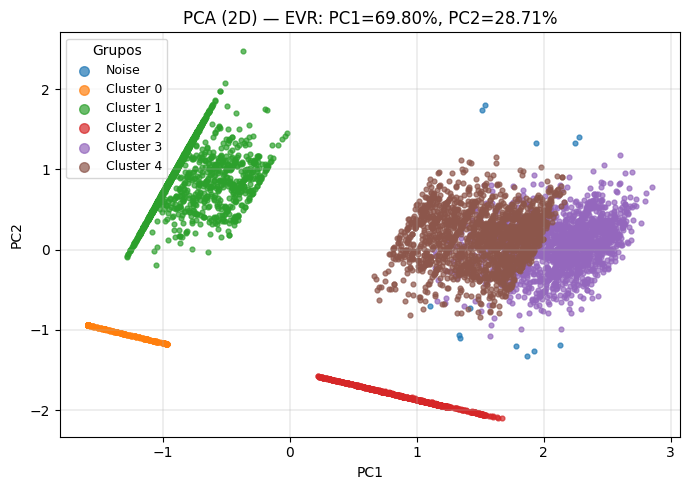

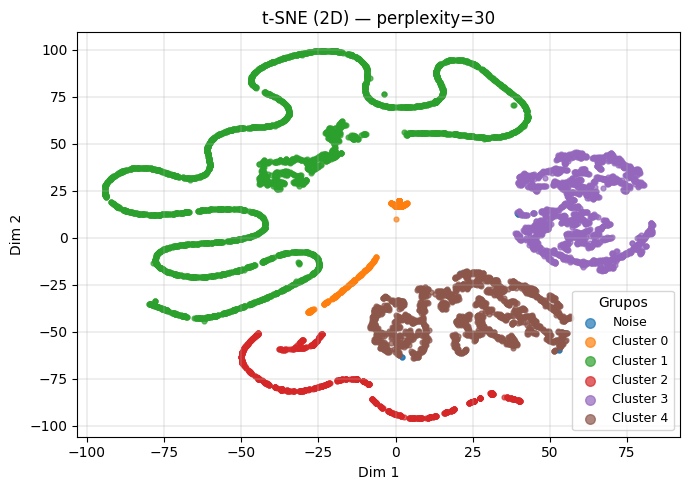

In [28]:

# --- PCA 2D ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(Xt)
evr = pca.explained_variance_ratio_
evr_txt = f"EVR: PC1={evr[0]:.2%}, PC2={evr[1]:.2%}"

plt.figure(figsize=(7,5))
unique_labels = np.unique(labels)
for lab in unique_labels:
    mask = labels == lab
    nome = f"Cluster {lab}" if lab != -1 else "Noise"
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=12, alpha=0.7, label=nome)
plt.title(f"PCA (2D) — {evr_txt}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Grupos", markerscale=2, fontsize=9)
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()

# --- t-SNE 2D ---from sklearn.manifold import TSNE

n = Xt.shape[0]
perplexity = max(5, min(30, (n - 1) // 3))  # valor seguro

tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    init="pca",
    learning_rate="auto",
    max_iter=1000,     
    random_state=42,
    verbose=0
)
X_tsne = tsne.fit_transform(Xt)

plt.figure(figsize=(7,5))
for lab in np.unique(labels):
    mask = labels == lab
    nome = f"Cluster {lab}" if lab != -1 else "Noise"
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], s=12, alpha=0.7, label=nome)
plt.title(f"t-SNE (2D) — perplexity={perplexity}")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(title="Grupos", markerscale=2, fontsize=9)
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()
